## Формулировка задачи

__Описание данных__
Вам представлены данные о доходах сотрудников участка горячего проката за год, в том числе данные, описывающие специфику рабочих мест.

_Задание_
- Выявите тип и формулу зависимости оклада, премии и доплат от приведенных в таблице данных
- Выявите все возможные зависимости между размерами оклада, премии и доплат


__В таблице нет разделения на оклад, премию и доплату, есть только колонка "Доход", при поиске зависимостей будем ориентироваться на ее__

## Первичный анализ данных

In [61]:
#импортируем необходимые библиотеки
import pandas as pd
import numpy as np

pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from catboost import Pool

In [80]:
#загружаем данные
data = pd.read_excel('База данных.xlsx') 

In [5]:
#проверяем, что получилось
data.head()

,Месяц,Профессия,Разряд,Оборудование,Вредность (балл.),Объем производства,Доход
0,2009-01-01,Нагревальщик металла,7,Нагревательные печи,22,580,26020.0
1,2009-01-01,Нагревальщик металла,6,Нагревательные печи,22,580,22980.0
2,2009-01-01,Нагревальщик металла,5,"Нагревательные печи, нагрев",22,580,20350.0
3,2009-01-01,Нагревальщик металла,5,"Нагревательные печи, кантовка",22,580,20350.0
4,2009-01-01,Нагревальщик металла,4,Нагревательные печи,22,580,18090.0


In [6]:
# посмотрим на информацию о датасете
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Месяц               264 non-null    datetime64[ns]
 1   Профессия           264 non-null    object        
 2   Разряд              264 non-null    int64         
 3   Оборудование        264 non-null    object        
 4   Вредность (балл.)   264 non-null    int64         
 5   Объем производства  264 non-null    int64         
 6   Доход               264 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 14.6+ KB


In [9]:
#выведем основные статистические характеристики данных по каждому числовому признаку
data.describe()

,Разряд,Вредность (балл.),Объем производства,Доход
count,264.000000,264.000000,264.000000,264.000000
mean,4.909091,15.681818,988.333333,21030.461230
std,1.313600,6.682726,231.372715,4323.920780
min,3.000000,0.000000,580.000000,12180.000000
25%,4.000000,11.000000,805.000000,17830.000000
50%,5.000000,18.000000,985.000000,20350.000000
75%,6.000000,22.000000,1185.000000,23818.014706
max,7.000000,22.000000,1400.000000,33157.058824


In [10]:
#посмотрим статистику по нечисловым признакам
data.describe(include = ['object'])

,Профессия,Оборудование
count,264,264
unique,9,9
top,Вальцовщик,Пилигримовые станы
freq,60,72


In [11]:
#оценим, много ли у нас пропусков в датасете
data.isna().sum()

Месяц                 0
Профессия             0
Разряд                0
Оборудование          0
Вредность (балл.)     0
Объем производства    0
Доход                 0
dtype: int64

Напишем функцию, которая покажет нам распределение признаков, выдаст процент пропусков и покажет выбросы для столбцов, у которых определены значения (но таких признаков нет)

In [12]:
def desription(col, boundaries = None):
    print('Столбец', col)
    print('Распределение признака:')
    fig, ax = plt.subplots()
    if data.loc[:, col].dtypes == np.dtype('O'): # Проверка на строковый тип данных
        sns.countplot(data.loc[:, col], ax=ax)
        plt.show()
    else:
        
        data.loc[:, col].hist(ax=ax)
        ax.set_xlabel(col)
        ax.set_ylabel('count')
        plt.show()
        if boundaries is not None: # Проверка на наличие выбросов по информации из датасета
            if data.loc[(~data.loc[:, col].between(boundaries[0], boundaries[1]))&
                       pd.notnull(data.loc[:, col])].shape[0] > 0:
                print('Найдены выбросы:')
                display(data.loc[(~data.loc[:, col].between(boundaries[0], boundaries[1]))&
                       pd.notnull(data.loc[:, col])])
                
    print('Процент пропусков:', str(round(100 - data.loc[:, col].count()/data.shape[0]*100, 2)) + '%')
    print()
    print('Детальное описание:')
    print(data.loc[:, col].describe())

Столбец Месяц
Распределение признака:


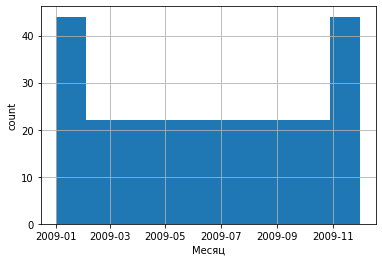

Процент пропусков: 0.0%

Детальное описание:
count                     264
unique                     12
top       2009-09-01 00:00:00
freq                       22
first     2009-01-01 00:00:00
last      2009-12-01 00:00:00
Name: Месяц, dtype: object
Столбец Профессия
Распределение признака:


/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.


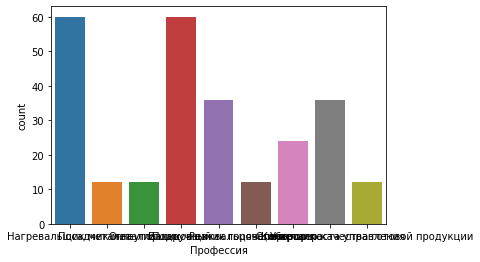

Процент пропусков: 0.0%

Детальное описание:
count            264
unique             9
top       Вальцовщик
freq              60
Name: Профессия, dtype: object
Столбец Разряд
Распределение признака:


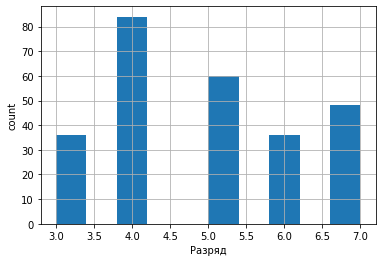

Процент пропусков: 0.0%

Детальное описание:
count    264.000000
mean       4.909091
std        1.313600
min        3.000000
25%        4.000000
50%        5.000000
75%        6.000000
max        7.000000
Name: Разряд, dtype: float64
Столбец Оборудование
Распределение признака:


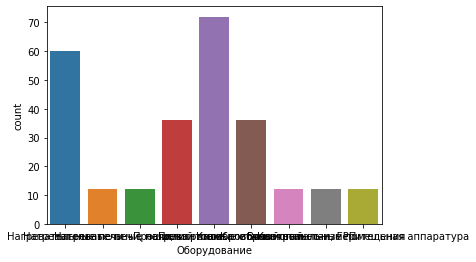

Процент пропусков: 0.0%

Детальное описание:
count                    264
unique                     9
top       Пилигримовые станы
freq                      72
Name: Оборудование, dtype: object
Столбец Вредность (балл.)
Распределение признака:


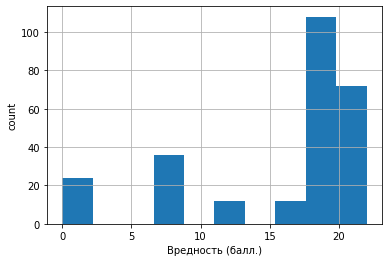

Процент пропусков: 0.0%

Детальное описание:
count    264.000000
mean      15.681818
std        6.682726
min        0.000000
25%       11.000000
50%       18.000000
75%       22.000000
max       22.000000
Name: Вредность (балл.), dtype: float64
Столбец Объем производства
Распределение признака:


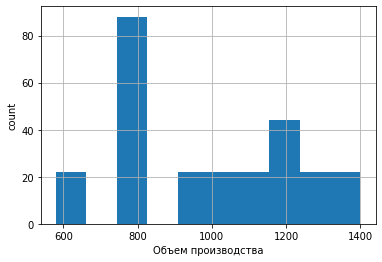

Процент пропусков: 0.0%

Детальное описание:
count     264.000000
mean      988.333333
std       231.372715
min       580.000000
25%       805.000000
50%       985.000000
75%      1185.000000
max      1400.000000
Name: Объем производства, dtype: float64
Столбец Доход
Распределение признака:


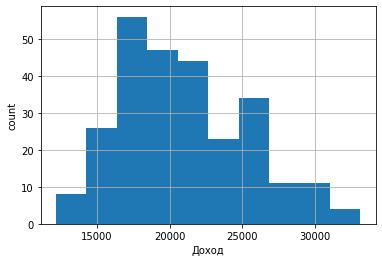

Процент пропусков: 0.0%

Детальное описание:
count      264.000000
mean     21030.461230
std       4323.920780
min      12180.000000
25%      17830.000000
50%      20350.000000
75%      23818.014706
max      33157.058824
Name: Доход, dtype: float64


In [13]:
for col in data.columns:
    desription(col)

оценим, как выглядят категориальные признаки для всего датафрейма

In [45]:
# Функция для построения диаграммы и вывода знаничей признака
def get_gr_counts(df, col):
    print('Признак ', col)
    print()
    print(df[col].value_counts())
    print()
    print()
    df[col].value_counts(ascending=True).plot(
        kind='barh', title=col, cmap='coolwarm')

Признак  Профессия

Вальцовщик                              60
Нагревальщик металла                    60
Подручный вальцовщика                   36
Оператор поста управления               36
Уборщик                                 24
Огнеупорщик                             12
Контролер качества готовой продукции    12
Резчик горячего металла                 12
Посадчик металла                        12
Name: Профессия, dtype: int64




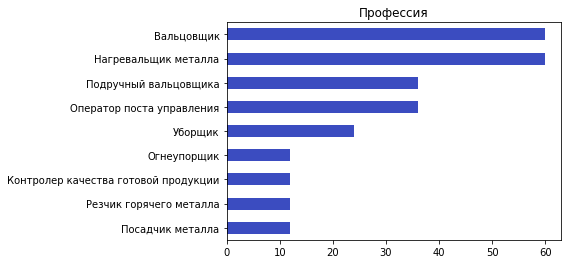

In [46]:
get_gr_counts(data, 'Профессия')

Признак  Оборудование

Пилигримовые станы                     72
Нагревательные печи                    60
Калибровочный стан                     36
Прошивной стан                         36
Вспомогательные помещения              12
Калибровочный стан, ГРП                12
Контрольно-измерительная аппаратура    12
Нагревательные печи, кантовка          12
Нагревательные печи, нагрев            12
Name: Оборудование, dtype: int64




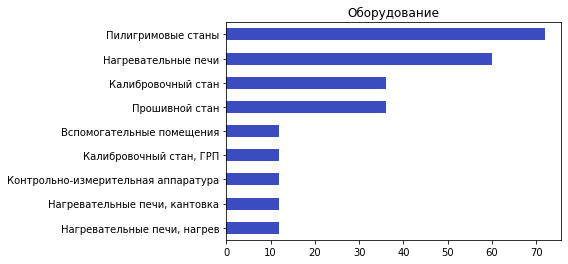

In [47]:
get_gr_counts(data, 'Оборудование')

## Зависимости между признаками

In [17]:
#посмотрим на среднюю зп по професии
grouped = data.groupby('Профессия', as_index=False)['Доход'].mean()
# добавим сортировку по убыванию
grouped.sort_values(by='Доход', ascending=False)

,Профессия,Доход
0,Вальцовщик,25007.955882
1,Контролер качества готовой продукции,24363.323529
2,Нагревальщик металла,23395.438235
6,Посадчик металла,19565.338235
4,Оператор поста управления,18709.318627
7,Резчик горячего металла,18485.338235
5,Подручный вальцовщика,18127.470588
3,Огнеупорщик,17585.338235
8,Уборщик,15071.735294


In [19]:
#Добавим еще подсчет минимума, максимума и медианы по каждой професии
data.groupby('Профессия')['Доход'].agg(['mean', 'min', 'max', 'median'])

,mean,min,max,median
Профессия,,,,
Вальцовщик,25007.955882,19630.0,32437.058824,25300.000000
Контролер качества готовой продукции,24363.323529,22060.0,29197.058824,23811.823529
Нагревальщик металла,23395.438235,18090.0,33157.058824,22980.000000
Огнеупорщик,17585.338235,16110.0,20681.470588,17232.088235
Оператор поста управления,18709.318627,15570.0,23132.647059,18071.441176
Подручный вальцовщика,18127.470588,15420.0,21941.470588,17577.176471
Посадчик металла,19565.338235,18090.0,22661.470588,19212.088235
Резчик горячего металла,18485.338235,17010.0,21581.470588,18132.088235
Уборщик,15071.735294,12180.0,19360.588235,15420.000000


In [32]:
#cгруппируем одновременно по профессии, и разряду, и по оборудованию
data.groupby(['Профессия', 'Разряд', 'Оборудование'], as_index=False)['Доход'].mean()

,Профессия,Разряд,Оборудование,Доход
0,Вальцовщик,5,Калибровочный стан,21341.308824
1,Вальцовщик,6,Пилигримовые станы,24245.911765
2,Вальцовщик,6,Прошивной стан,24245.911765
3,Вальцовщик,7,Пилигримовые станы,27603.323529
4,Вальцовщик,7,Прошивной стан,27603.323529
5,Контролер качества готовой продукции,7,Контрольно-измерительная аппаратура,24363.323529
6,Нагревальщик металла,4,Нагревательные печи,19565.338235
7,Нагревальщик металла,5,"Нагревательные печи, кантовка",22061.308824
8,Нагревальщик металла,5,"Нагревательные печи, нагрев",22061.308824
9,Нагревальщик металла,6,Нагревательные печи,24965.911765


In [ ]:
в рамках одной профессии и разряда вне зависимости от оборудования средний доход одинаков кроме уборщика 

In [33]:
#Добавим еще подсчет минимума, максимума и медианы по каждой професии
data.groupby(['Профессия', 'Разряд', 'Оборудование'], as_index=False)['Доход'].agg(['mean', 'min', 'max', 'median'])

mean  \
Профессия                            Разряд Оборудование                                        
Вальцовщик                           5      Калибровочный стан                   21341.308824   
                                     6      Пилигримовые станы                   24245.911765   
                                            Прошивной стан                       24245.911765   
                                     7      Пилигримовые станы                   27603.323529   
                                            Прошивной стан                       27603.323529   
Контролер качества готовой продукции 7      Контрольно-измерительная аппаратура  24363.323529   
Нагревальщик металла                 4      Нагревательные печи                  19565.338235   
                                     5      Нагревательные печи, кантовка        22061.308824   
                                            Нагревательные печи, нагрев          22061.308824   
                                     6      Нагревательные печи                  24965.911765   
                                     7      Нагревательные печи                  28323.323529   
Огнеупорщик                          4      Нагревательные печи                  17585.338235   
Оператор поста управления            4      Калибровочный стан                   17045.338235   
                                     5      Калибровочный стан                   19541.308824   
                                            Калибровочный стан, ГРП              19541.308824   
Подручный вальцовщика                3      Пилигримовые станы                   16691.735294   
                                     4      Пилигримовые станы                   18845.338235   
                                            Прошивной стан                       18845.338235   
Посадчик металла                     4      Нагревательные печи                  19565.338235   
Резчик горячего металла              4      Пилигримовые станы                   18485.338235   
Уборщик                              3      Вспомогательные помещения            13451.735294   
                                            Пилигримовые станы                   16691.735294   

                                                                                     min  \
Профессия                            Разряд Оборудование                                   
Вальцовщик                           5      Калибровочный стан                   19630.0   
                                     6      Пилигримовые станы                   22260.0   
                                            Прошивной стан                       22260.0   
                                     7      Пилигримовые станы                   25300.0   
                                            Прошивной стан                       25300.0   
Контролер качества готовой продукции 7      Контрольно-измерительная аппаратура  22060.0   
Нагревальщик металла                 4      Нагревательные печи                  18090.0   
                                     5      Нагревательные печи, кантовка        20350.0   
                                            Нагревательные печи, нагрев          20350.0   
                                     6      Нагревательные печи                  22980.0   
                                     7      Нагревательные печи                  26020.0   
Огнеупорщик                          4      Нагревательные печи                  16110.0   
Оператор поста управления            4      Калибровочный стан                   15570.0   
                                     5      Калибровочный стан                   17830.0   
                                            Калибровочный стан, ГРП              17830.0   
Подручный вальцовщика                3      Пилигримовые станы                   15420.0   
                                     4      Пилигримовые станы                   17370.0   
            

еще раз убедились, что только у уборщика есть различие в зп в зависимости от оборудования

In [34]:
#Добавим сортировку внутри групп
data.groupby(['Профессия', 'Разряд', 'Оборудование']).apply(lambda x: x.sort_values(by='Доход', ascending=False))

Месяц   Профессия  Разряд  \
Профессия  Разряд Оборудование                                            
Вальцовщик 5      Калибровочный стан 136 2009-07-01  Вальцовщик       5   
                                     96  2009-05-01  Вальцовщик       5   
                                     76  2009-04-01  Вальцовщик       5   
                                     156 2009-08-01  Вальцовщик       5   
                                     176 2009-09-01  Вальцовщик       5   
...                                             ...         ...     ...   
Уборщик    3      Пилигримовые станы 15  2009-01-01     Уборщик       3   
                                     35  2009-02-01     Уборщик       3   
                                     55  2009-03-01     Уборщик       3   
                                     195 2009-10-01     Уборщик       3   
                                     235 2009-12-01     Уборщик       3   

                                                Оборудование  \
Профессия  Разряд Оборудование                                 
Вальцовщик 5      Калибровочный стан 136  Калибровочный стан   
                                     96   Калибровочный стан   
                                     76   Калибровочный стан   
                                     156  Калибровочный стан   
                                     176  Калибровочный стан   
...                                                      ...   
Уборщик    3      Пилигримовые станы 15   Пилигримовые станы   
                                     35   Пилигримовые станы   
                                     55   Пилигримовые станы   
                                     195  Пилигримовые станы   
                                     235  Пилигримовые станы   

                                          Вредность (балл.)  \
Профессия  Разряд Оборудование                                
Вальцовщик 5      Калибровочный стан 136                 18   
                                     96                  18   
                                     76                  18   
                                     156                 18   
                                     176                 18   
...                                                     ...   
Уборщик    3      Пилигримовые станы 15                  18   
                                     35                  18   
                                     55                  18   
                                     195                 18   
                                     235                 18   

                                          Объем производства         Доход  
Профессия  Разряд Оборудование                                              
Вальцовщик 5      Калибровочный стан 136                1400  24932.647059  
                                     96                 1250  23486.470588  
                                     76                 1200  23004.411765  
                                     156                1180  22811.588235  
                                     176                1080  21847.470588  
...                                                      ...           ...  
Уборщик    3      Пилигримовые станы 15                  580  15420.000000  
                                     35                  790  15420.000000  
                                     55                  820  15420.000000  
                                     195                 780  15420.000000  
                                     235                 810  15420.000000  

[264 rows x 7 columns]

In [35]:
#удалим лишние колонки
data.groupby(['Профессия', 'Разряд', 'Оборудование']).apply(lambda x: x.sort_values(by='Доход', ascending=False)).\
                                                    drop(['Профессия', 'Разряд'], axis=1)

Месяц        Оборудование  \
Профессия  Разряд Оборудование                                            
Вальцовщик 5      Калибровочный стан 136 2009-07-01  Калибровочный стан   
                                     96  2009-05-01  Калибровочный стан   
                                     76  2009-04-01  Калибровочный стан   
                                     156 2009-08-01  Калибровочный стан   
                                     176 2009-09-01  Калибровочный стан   
...                                             ...                 ...   
Уборщик    3      Пилигримовые станы 15  2009-01-01  Пилигримовые станы   
                                     35  2009-02-01  Пилигримовые станы   
                                     55  2009-03-01  Пилигримовые станы   
                                     195 2009-10-01  Пилигримовые станы   
                                     235 2009-12-01  Пилигримовые станы   

                                          Вредность (балл.)  \
Профессия  Разряд Оборудование                                
Вальцовщик 5      Калибровочный стан 136                 18   
                                     96                  18   
                                     76                  18   
                                     156                 18   
                                     176                 18   
...                                                     ...   
Уборщик    3      Пилигримовые станы 15                  18   
                                     35                  18   
                                     55                  18   
                                     195                 18   
                                     235                 18   

                                          Объем производства         Доход  
Профессия  Разряд Оборудование                                              
Вальцовщик 5      Калибровочный стан 136                1400  24932.647059  
                                     96                 1250  23486.470588  
                                     76                 1200  23004.411765  
                                     156                1180  22811.588235  
                                     176                1080  21847.470588  
...                                                      ...           ...  
Уборщик    3      Пилигримовые станы 15                  580  15420.000000  
                                     35                  790  15420.000000  
                                     55                  820  15420.000000  
                                     195                 780  15420.000000  
                                     235                 810  15420.000000  

[264 rows x 5 columns]

In [36]:
#Посмотрим, что с вредностью
data.groupby(['Профессия', 'Разряд', 'Оборудование'], as_index=False)['Вредность (балл.)'].agg(['mean', 'min', 'max', 'median'])

mean  \
Профессия                            Разряд Оборудование                                
Вальцовщик                           5      Калибровочный стан                     18   
                                     6      Пилигримовые станы                     18   
                                            Прошивной стан                         18   
                                     7      Пилигримовые станы                     18   
                                            Прошивной стан                         18   
Контролер качества готовой продукции 7      Контрольно-измерительная аппаратура     0   
Нагревальщик металла                 4      Нагревательные печи                    22   
                                     5      Нагревательные печи, кантовка          22   
                                            Нагревательные печи, нагрев            22   
                                     6      Нагревательные печи                    22   
                                     7      Нагревательные печи                    22   
Огнеупорщик                          4      Нагревательные печи                    11   
Оператор поста управления            4      Калибровочный стан                      8   
                                     5      Калибровочный стан                      8   
                                            Калибровочный стан, ГРП                 8   
Подручный вальцовщика                3      Пилигримовые станы                     18   
                                     4      Пилигримовые станы                     18   
                                            Прошивной стан                         18   
Посадчик металла                     4      Нагревательные печи                    22   
Резчик горячего металла              4      Пилигримовые станы                     16   
Уборщик                              3      Вспомогательные помещения               0   
                                            Пилигримовые станы                     18   

                                                                                 min  \
Профессия                            Разряд Оборудование                               
Вальцовщик                           5      Калибровочный стан                    18   
                                     6      Пилигримовые станы                    18   
                                            Прошивной стан                        18   
                                     7      Пилигримовые станы                    18   
                                            Прошивной стан                        18   
Контролер качества готовой продукции 7      Контрольно-измерительная аппаратура    0   
Нагревальщик металла                 4      Нагревательные печи                   22   
                                     5      Нагревательные печи, кантовка         22   
                                            Нагревательные печи, нагрев           22   
                                     6      Нагревательные печи                   22   
                                     7      Нагревательные печи                   22   
Огнеупорщик                          4      Нагревательные печи                   11   
Оператор поста управления            4      Калибровочный стан                     8   
                                     5      Калибровочный стан                     8   
                                            Калибровочный стан, ГРП                8   
Подручный вальцовщика                3      Пилигримовые станы                    18   
                                     4      Пилигримовые станы                    18   
                                            Прошивной стан                        18   
Посадчик металла                     4      Нагревательные печи                   22   
Резчик горячего металла              4      Пилигримовые станы                    16   
Уборщик 

в рамках одной профессии и разряда вне зависимости от оборудования вредность одинакова у всех кроме Уборщик

In [31]:
#посмотрим, что с объемами производства по месяцам 
data.groupby('Месяц')['Объем производства'].agg(['mean', 'min', 'max', 'median'])

,mean,min,max,median
Месяц,,,,
2009-01-01,580,580,580,580
2009-02-01,790,790,790,790
2009-03-01,820,820,820,820
2009-04-01,1200,1200,1200,1200
2009-05-01,1250,1250,1250,1250
2009-06-01,950,950,950,950
2009-07-01,1400,1400,1400,1400
2009-08-01,1180,1180,1180,1180
2009-09-01,1080,1080,1080,1080


объем производства по месяцам одинаков

In [39]:
##Оценим среднее, минимум, максимум и медиану дохода в зависимости от месяца
data.groupby('Месяц')['Доход'].agg(['mean', 'min', 'max', 'median'])

,mean,min,max,median
Месяц,,,,
2009-01-01,19309.090909,12180.000000,26020.000000,18090.000000
2009-02-01,19309.090909,12180.000000,26020.000000,18090.000000
2009-03-01,19309.090909,12180.000000,26020.000000,18090.000000
2009-04-01,22703.342246,14687.647059,30561.764706,21204.411765
2009-05-01,23188.235294,15045.882353,31210.588235,21686.470588
2009-06-01,20278.877005,12896.470588,27317.647059,18921.176471
2009-07-01,24642.914439,16120.588235,33157.058824,23132.647059
2009-08-01,22509.385027,14544.352941,30302.235294,21011.588235
2009-09-01,21539.598930,13827.882353,29004.588235,20047.470588


Несмотря на то, что объемы производства были разные за каждый месяц, не всегда доход менялся

Посмотрим, есть ли линейная зависимость между числовыми признаками и таргетом (доход)

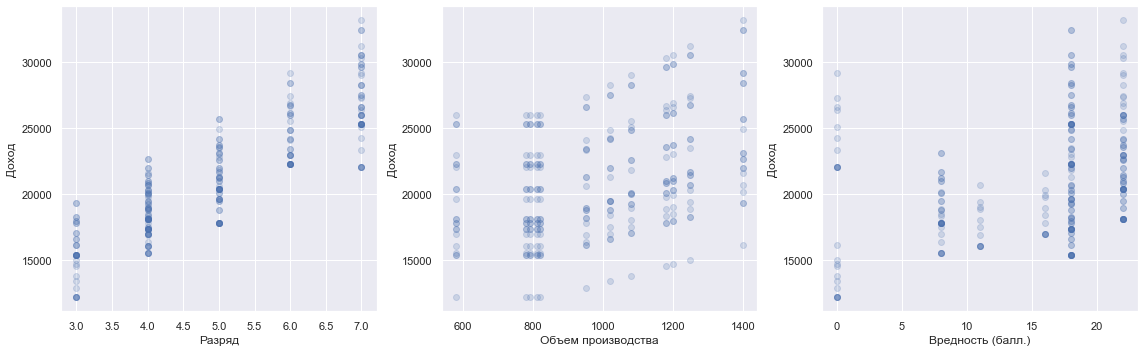

In [158]:
fig, axs = plt.subplots(figsize=(16, 5), ncols=3)
for i, feature in enumerate(["Разряд", "Объем производства", "Вредность (балл.)"]):
    axs[i].scatter(X[feature], y, alpha=0.2)
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel("Доход")
plt.tight_layout()

Между этими признаками и целевой переменной не наблюдается линейной зависимости

## Корреляционный анализ

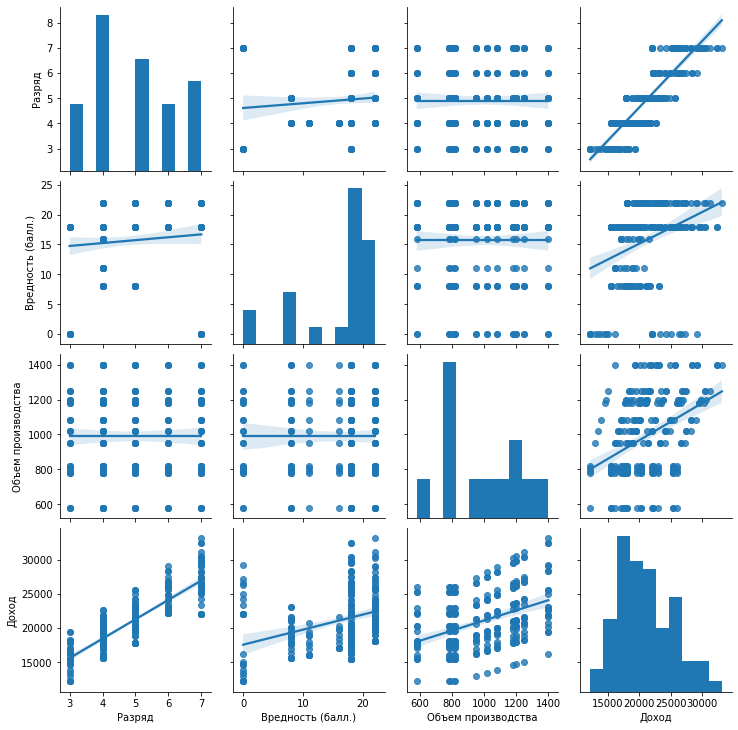

In [49]:
sns.pairplot(data, kind = 'reg')

еще раз убедимся в отсутствии линейной зависимости между признаками и таргетом

In [50]:
#посмотрим на матрицу корреляции
data.corr()

,Разряд,Вредность (балл.),Объем производства,Доход
Разряд,1.000000e+00,9.544813e-02,-5.689043e-18,0.865148
Вредность (балл.),9.544813e-02,1.000000e+00,2.907515e-17,0.342187
Объем производства,-5.689043e-18,2.907515e-17,1.000000e+00,0.398179
Доход,8.651476e-01,3.421866e-01,3.981793e-01,1.000000


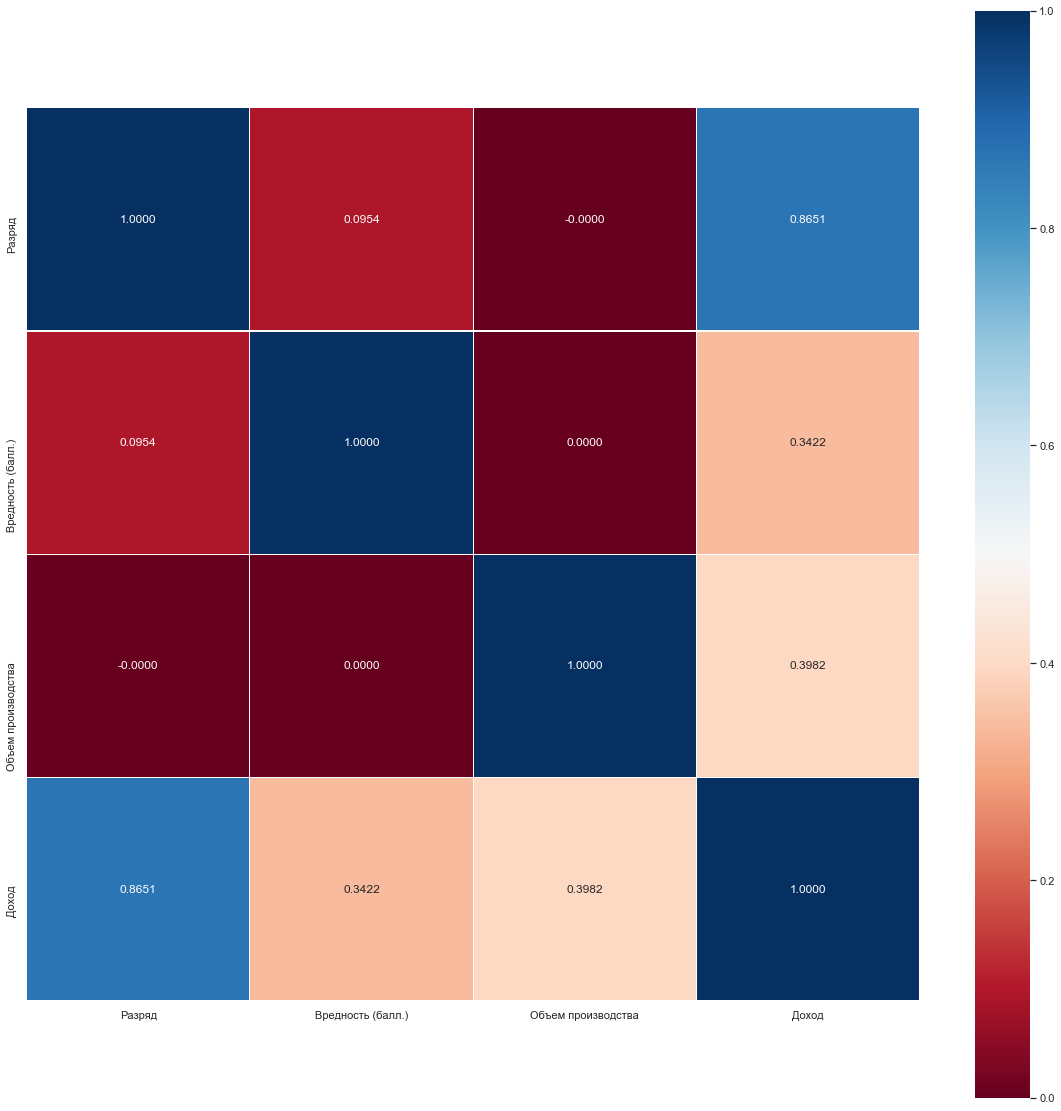

In [129]:
#строим тепловую карту 
sns.set(font_scale=1)
plt.subplots(figsize=(20, 20))
sns.heatmap(data.corr(), square=True,
              annot=True, fmt=".4f", linewidths=0.1, cmap="RdBu")

Мультиколлинеарности не наблюдаем

Для корреляции есть пороги: <0.3 слабая, 0.3-0.7 умеренная, >0.7 сильная.

Вредность и объем производства умеренно положительно коррелируют с целевой переменной (доход), а разряд - сильно положительно коррелирует. И в целом это выглядит логично, что чем больше вредность, рязряд и объем производства, тем больше доход сотрудника.

## Анализ номинативных переменных

По факту, только один признак является действительно числовым - это объем производства. Несмотря на то, что данные в стобцах Вредность и Рязряд являются числовыми, фактически это категориальные признаки (данные не являются непрерывными), поэтому проанализируем их как номинативные переменные

Напишем функцию, которая для номинативных переменных покажет распределение дохода в зависимости от признака, а также покажет статистическую значимость этих различий.

Очевидно, что для номинативных переменных использовать корреляционный анализ не получится. Однако можно посмотреть, различаются ли распределения дохода в зависимости от значения этих переменных. Это можно сделать, например, с помощью box-plot или KDE-plot (график показывает плотность распределения переменных).

In [154]:
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y='Доход', 
                data=data.loc[data.loc[:, column].isin(data.loc[:, column].value_counts().index)],
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

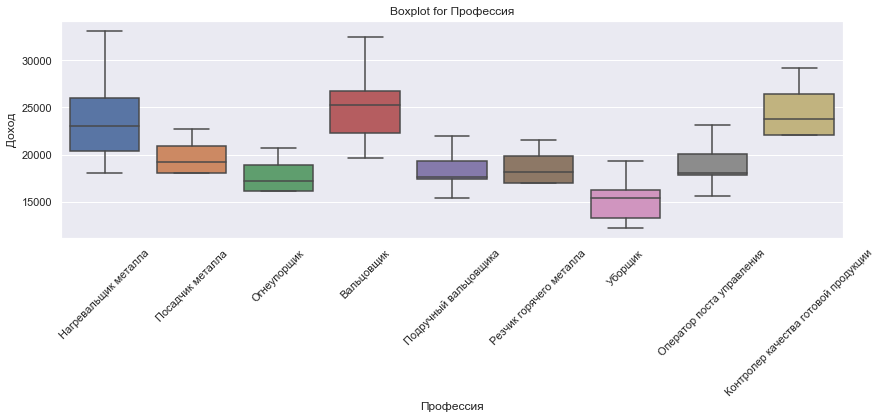

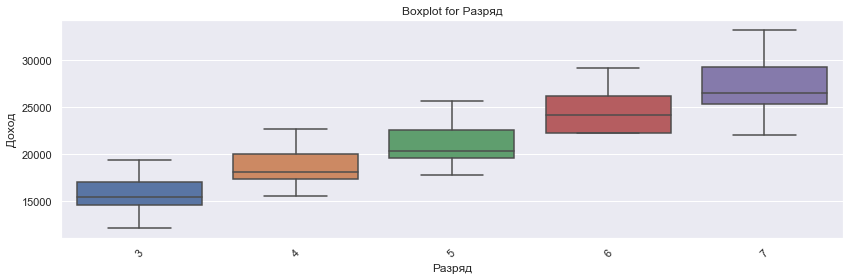

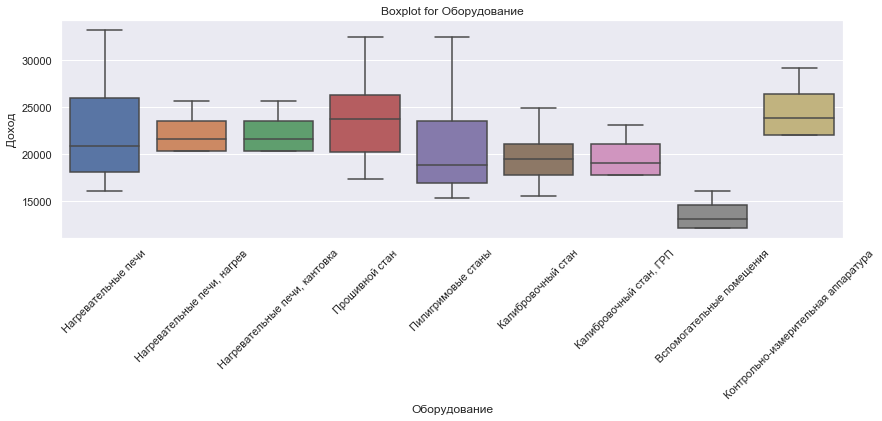

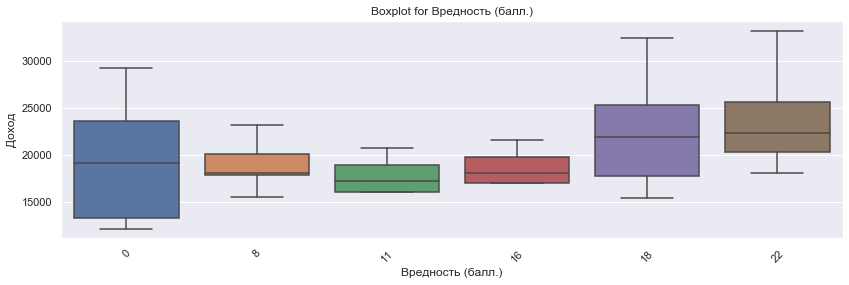

In [159]:
for col in ['Профессия', 'Разряд', 'Оборудование', 'Вредность (балл.)']:
    get_boxplot(col)

По графикам похоже, что все параметры могут влиять на Доход. Однако графики являются лишь вспомогательным инструментом, настоящую значимость различий может помочь распознать статистика. Проверим, есть ли статистическая разница в распределении дохода по разным признакам, с помощью теста Стьюдента. Проверим нулевую гипотезу о том, что распределение дохода по различным параметрам неразличимы:

In [66]:
# Функция для проверки статистической разницы в распределении дохода
# с помощью теста Стьюдента встроенного в функцию ttest_ind()
def get_stat_dif(column):
    # На входе имеем имя столбца с нечисловыми (номинативными) данными
    # Проверяем характер распределения оценок в зависимости от значений в этом столбце
    cols = data.loc[:, column].value_counts().index
    # Создаём все возможные парные комбинации из элементов списка cols 
    combinations_all = list(combinations(cols, 2))
    # Для каждой пары номинативных значений рассматриваемого столбца
    # выполняем тест Стьюдента 
    for comb in combinations_all:
        # Готовим аргументы для функции ttest_ind()
        if ttest_ind(data.loc[data.loc[:, column] == comb[0], 'Доход'], 
                        data.loc[data.loc[:, column] == comb[1], 'Доход'], nan_policy='omit').pvalue \
            <= 0.05/len(combinations_all): 
            print('Найдены статистически значимые различия для колонки', column)
            break

In [160]:
for col in ['Профессия', 'Разряд', 'Оборудование', 'Вредность (балл.)']:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки Профессия
Найдены статистически значимые различия для колонки Разряд
Найдены статистически значимые различия для колонки Оборудование
Найдены статистически значимые различия для колонки Вредность (балл.)


## Модель

Для описания зависимостей между факторами и таргетом нужно выбрать модель. Простая линейная регрессия даст не самый хороший результат (уже на графике видно отсутствие линейной зависимости). И поскольку у нас есь категориальные фичи, то попробуем использовать Catboost и посмотрим на результаты

### Catboost

Создадим список категориальных признаков для передачи списка в классификатор cat boost 

In [81]:
cat_cols = ['Профессия', 'Оборудование']

<span class="burk">преобразовать месяц - сделать кат фичу</span>

In [83]:
# Подготовим данные для обучения модели
y = data["Доход"]
#месяц тоже удалим, не думаю, что будет четкая связь между названием месяца и доходом
X = data.drop(columns=["Доход", 'Месяц'])
#разобьем выборку на тест и трейн
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [88]:
#определим модель
model = CatBoostRegressor(iterations=1000)

In [90]:
train_pool = Pool(X_train, y_train, cat_features=cat_cols)
test_pool = Pool(X_test, cat_features=cat_cols)

In [ ]:
#подберем параметры с помощью сетки (долго считается без GPU, порядка 3-4 часов)
grid = {
    'learning_rate': [0.03, 0.1],
    'depth':[4, 6, 8, 10, 12],
    'l2_leaf_reg': [0,5, 1, 3, 5, 7, 9],
    'iterations': [1000, 2000, 3000, 4000, 5000, 6000],
    'bootstrap_type': ['Bayesian', 'Bernoulli', 'MVS', None],
    #'eval_metric': ['MAPE'],
    'od_type': ['Iter', 'IncToDec']  
}
grid_search_results = model.grid_search(grid, train_pool, shuffle=False, verbose=True, plot=True)

#### подбор гиперпараметров (скрыла промежуточные вычисления, иначе в pdf выводится больше 100 страниц

In [92]:
#подберем параметры с помощью сетки (долго считается без GPU, порядка 3-4 часов)
grid = {
    'learning_rate': [0.03, 0.1],
    'depth':[4, 6, 8, 10, 12],
    'l2_leaf_reg': [0,5, 1, 3, 5, 7, 9],
    'iterations': [1000, 2000, 3000, 4000, 5000, 6000],
    'bootstrap_type': ['Bayesian', 'Bernoulli', 'MVS', None],
    #'eval_metric': ['MAPE'],
    'od_type': ['Iter', 'IncToDec']  
}
grid_search_results = model.grid_search(grid, train_pool, shuffle=False, verbose=True, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Stopped by overfitting detector  (20 iterations wait)

bestTest = 370.395839
bestIteration = 943

0:	loss: 370.3958390	best: 370.3958390 (0)	total: 1.09s	remaining: 1h 57s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 338.7190261
bestIteration = 797

1:	loss: 338.7190261	best: 338.7190261 (1)	total: 1.87s	remaining: 52m 13s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 425.526972
bestIteration = 833

2:	loss: 425.5269720	best: 338.7190261 (1)	total: 2.86s	remaining: 53m 17s

bestTest = 369.1105813
bestIteration = 999

3:	loss: 369.1105813	best: 338.7190261 (1)	total: 3.8s	remaining: 53m 6s

bestTest = 333.8993006
bestIteration = 999

4:	loss: 333.8993006	best: 333.8993006 (4)	total: 4.73s	remaining: 52m 56s

bestTest = 422.193108
bestIteration = 998

5:	loss: 422.1931080	best: 333.8993006 (4)	total: 5.66s	remaining: 52m 42s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 619.7541233
bestIteration = 471

6:	loss: 619.7541233	best


bestTest = 929.3417672
bestIteration = 999

61:	loss: 929.3417672	best: 168.5612056 (10)	total: 51.4s	remaining: 45m 32s

bestTest = 541.9397683
bestIteration = 999

62:	loss: 541.9397683	best: 168.5612056 (10)	total: 52.2s	remaining: 45m 33s

bestTest = 437.5536169
bestIteration = 999

63:	loss: 437.5536169	best: 168.5612056 (10)	total: 53.2s	remaining: 45m 37s

bestTest = 929.3417672
bestIteration = 999

64:	loss: 929.3417672	best: 168.5612056 (10)	total: 54s	remaining: 45m 37s

bestTest = 541.9397683
bestIteration = 999

65:	loss: 541.9397683	best: 168.5612056 (10)	total: 54.9s	remaining: 45m 37s

bestTest = 661.448465
bestIteration = 999

66:	loss: 661.4484650	best: 168.5612056 (10)	total: 55.8s	remaining: 45m 40s

bestTest = 1071.649375
bestIteration = 997

67:	loss: 1071.6493747	best: 168.5612056 (10)	total: 56.6s	remaining: 45m 38s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 523.1184675
bestIteration = 448

68:	loss: 523.1184675	best: 168.5612056 (10)	tota


bestTest = 847.4786983
bestIteration = 1999

121:	loss: 847.4786983	best: 167.3255745 (94)	total: 2m	remaining: 53m 27s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 342.4592382
bestIteration = 1531

122:	loss: 342.4592382	best: 167.3255745 (94)	total: 2m 2s	remaining: 53m 37s

bestTest = 474.9008387
bestIteration = 1999

123:	loss: 474.9008387	best: 167.3255745 (94)	total: 2m 4s	remaining: 53m 57s

bestTest = 847.4786983
bestIteration = 1999

124:	loss: 847.4786983	best: 167.3255745 (94)	total: 2m 5s	remaining: 54m 19s

bestTest = 333.9199545
bestIteration = 1997

125:	loss: 333.9199545	best: 167.3255745 (94)	total: 2m 7s	remaining: 54m 41s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 533.3732928
bestIteration = 861

126:	loss: 533.3732928	best: 167.3255745 (94)	total: 2m 8s	remaining: 54m 36s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 494.2716699
bestIteration = 742

127:	loss: 494.2716699	best: 167.3255745 (94)	total: 


bestTest = 635.1881815
bestIteration = 1518

179:	loss: 635.1881815	best: 166.9290158 (178)	total: 3m 11s	remaining: 56m 28s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 357.7182472
bestIteration = 2361

180:	loss: 357.7182472	best: 166.9290158 (178)	total: 3m 13s	remaining: 56m 34s

bestTest = 754.7975435
bestIteration = 2987

181:	loss: 754.7975435	best: 166.9290158 (178)	total: 3m 15s	remaining: 56m 45s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 436.9106722
bestIteration = 2879

182:	loss: 436.9106722	best: 166.9290158 (178)	total: 3m 16s	remaining: 56m 54s

bestTest = 351.5786049
bestIteration = 2996

183:	loss: 351.5786049	best: 166.9290158 (178)	total: 3m 18s	remaining: 57m 11s

bestTest = 754.7975435
bestIteration = 2987

184:	loss: 754.7975435	best: 166.9290158 (178)	total: 3m 20s	remaining: 57m 21s

bestTest = 435.6351558
bestIteration = 2998

185:	loss: 435.6351558	best: 166.9290158 (178)	total: 3m 22s	remaining: 57m 35s
Stopped by

Stopped by overfitting detector  (20 iterations wait)

bestTest = 1056.201739
bestIteration = 1406

235:	loss: 1056.2017388	best: 166.9290158 (178)	total: 4m 32s	remaining: 1h 2s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 523.1184675
bestIteration = 448

236:	loss: 523.1184675	best: 166.9290158 (178)	total: 4m 32s	remaining: 59m 50s

bestTest = 646.6311758
bestIteration = 2962

237:	loss: 646.6311758	best: 166.9290158 (178)	total: 4m 34s	remaining: 59m 57s

bestTest = 1042.531826
bestIteration = 2999

238:	loss: 1042.5318261	best: 166.9290158 (178)	total: 4m 35s	remaining: 1h 3s

bestTest = 508.3583581
bestIteration = 1820

239:	loss: 508.3583581	best: 166.9290158 (178)	total: 4m 37s	remaining: 1h 9s

bestTest = 550.4364335
bestIteration = 2997

240:	loss: 550.4364335	best: 166.9290158 (178)	total: 4m 39s	remaining: 1h 17s

bestTest = 746.6772536
bestIteration = 2998

241:	loss: 746.6772536	best: 166.9290158 (178)	total: 4m 41s	remaining: 1h 27s

bestTest = 495.7

Stopped by overfitting detector  (20 iterations wait)

bestTest = 342.4592382
bestIteration = 1531

290:	loss: 342.4592382	best: 166.8759404 (262)	total: 6m 1s	remaining: 1h 3m 31s

bestTest = 459.5359248
bestIteration = 3996

291:	loss: 459.5359248	best: 166.8759404 (262)	total: 6m 3s	remaining: 1h 3m 42s

bestTest = 820.1784591
bestIteration = 3998

292:	loss: 820.1784591	best: 166.8759404 (262)	total: 6m 6s	remaining: 1h 3m 54s

bestTest = 318.6834891
bestIteration = 3999

293:	loss: 318.6834891	best: 166.8759404 (262)	total: 6m 8s	remaining: 1h 4m 7s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 533.3732928
bestIteration = 861

294:	loss: 533.3732928	best: 166.8759404 (262)	total: 6m 9s	remaining: 1h 3m 58s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 494.2716699
bestIteration = 742

295:	loss: 494.2716699	best: 166.8759404 (262)	total: 6m 10s	remaining: 1h 3m 50s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 397.8639657



bestTest = 615.9641055
bestIteration = 981

345:	loss: 615.9641055	best: 166.8759404 (262)	total: 7m 39s	remaining: 1h 6m 42s

bestTest = 166.8727638
bestIteration = 4278

346:	loss: 166.8727638	best: 166.8727638 (346)	total: 7m 42s	remaining: 1h 6m 54s

bestTest = 635.1881815
bestIteration = 1518

347:	loss: 635.1881815	best: 166.8727638 (346)	total: 7m 45s	remaining: 1h 7m 7s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 357.7182472
bestIteration = 2361

348:	loss: 357.7182472	best: 166.8727638 (346)	total: 7m 47s	remaining: 1h 7m 10s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 753.6253436
bestIteration = 3056

349:	loss: 753.6253436	best: 166.8727638 (346)	total: 7m 48s	remaining: 1h 7m 13s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 436.9106722
bestIteration = 2879

350:	loss: 436.9106722	best: 166.8727638 (346)	total: 7m 50s	remaining: 1h 7m 17s

bestTest = 342.4802796
bestIteration = 4977

351:	loss: 342.4802796	bes


bestTest = 341.0008074
bestIteration = 4998

399:	loss: 341.0008074	best: 166.8727638 (346)	total: 9m 32s	remaining: 1h 10m 35s

bestTest = 764.5958397
bestIteration = 4998

400:	loss: 764.5958397	best: 166.8727638 (346)	total: 9m 35s	remaining: 1h 10m 44s

bestTest = 426.0759578
bestIteration = 4991

401:	loss: 426.0759578	best: 166.8727638 (346)	total: 9m 38s	remaining: 1h 10m 54s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 656.7686212
bestIteration = 1178

402:	loss: 656.7686212	best: 166.8727638 (346)	total: 9m 38s	remaining: 1h 10m 47s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1056.201739
bestIteration = 1406

403:	loss: 1056.2017388	best: 166.8727638 (346)	total: 9m 39s	remaining: 1h 10m 42s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 523.1184675
bestIteration = 448

404:	loss: 523.1184675	best: 166.8727638 (346)	total: 9m 40s	remaining: 1h 10m 33s

bestTest = 644.4723532
bestIteration = 4999

405:	loss: 644.472


bestTest = 535.9636923
bestIteration = 5998

453:	loss: 535.9636923	best: 166.8718207 (430)	total: 11m 28s	remaining: 1h 13m 29s

bestTest = 273.9268448
bestIteration = 5846

454:	loss: 273.9268448	best: 166.8718207 (430)	total: 11m 32s	remaining: 1h 13m 40s

bestTest = 475.0714314
bestIteration = 1053

455:	loss: 475.0714314	best: 166.8718207 (430)	total: 11m 35s	remaining: 1h 13m 51s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 464.7521098
bestIteration = 2682

456:	loss: 464.7521098	best: 166.8718207 (430)	total: 11m 37s	remaining: 1h 13m 52s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 828.285939
bestIteration = 2960

457:	loss: 828.2859390	best: 166.8718207 (430)	total: 11m 39s	remaining: 1h 13m 52s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 342.4592382
bestIteration = 1531

458:	loss: 342.4592382	best: 166.8718207 (430)	total: 11m 40s	remaining: 1h 13m 48s

bestTest = 456.1471623
bestIteration = 5999

459:	loss: 45

Stopped by overfitting detector  (20 iterations wait)

bestTest = 710.6970074
bestIteration = 626

506:	loss: 710.6970074	best: 166.8718207 (430)	total: 13m 35s	remaining: 1h 16m 27s

bestTest = 726.5632969
bestIteration = 966

507:	loss: 726.5632969	best: 166.8718207 (430)	total: 13m 36s	remaining: 1h 16m 23s

bestTest = 954.3058052
bestIteration = 999

508:	loss: 954.3058052	best: 166.8718207 (430)	total: 13m 37s	remaining: 1h 16m 19s

bestTest = 707.5384579
bestIteration = 994

509:	loss: 707.5384579	best: 166.8718207 (430)	total: 13m 38s	remaining: 1h 16m 14s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 928.6034432
bestIteration = 268

510:	loss: 928.6034432	best: 166.8718207 (430)	total: 13m 38s	remaining: 1h 16m 5s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1505.33216
bestIteration = 265

511:	loss: 1505.3321599	best: 166.8718207 (430)	total: 13m 39s	remaining: 1h 15m 56s
Stopped by overfitting detector  (20 iterations wait)

bestTest =


bestTest = 1065.59554
bestIteration = 998

564:	loss: 1065.5955401	best: 166.8718207 (430)	total: 14m 30s	remaining: 1h 11m 45s

bestTest = 908.8705727
bestIteration = 999

565:	loss: 908.8705727	best: 166.8718207 (430)	total: 14m 31s	remaining: 1h 11m 41s

bestTest = 1219.269359
bestIteration = 999

566:	loss: 1219.2693591	best: 166.8718207 (430)	total: 14m 32s	remaining: 1h 11m 37s

bestTest = 1065.59554
bestIteration = 998

567:	loss: 1065.5955401	best: 166.8718207 (430)	total: 14m 33s	remaining: 1h 11m 32s

bestTest = 908.8705727
bestIteration = 999

568:	loss: 908.8705727	best: 166.8718207 (430)	total: 14m 34s	remaining: 1h 11m 28s

bestTest = 1219.269359
bestIteration = 999

569:	loss: 1219.2693591	best: 166.8718207 (430)	total: 14m 35s	remaining: 1h 11m 24s

bestTest = 614.9448303
bestIteration = 995

570:	loss: 614.9448303	best: 166.8718207 (430)	total: 14m 36s	remaining: 1h 11m 20s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1045.538291
bestIteration = 7


bestTest = 944.3694082
bestIteration = 1944

621:	loss: 944.3694082	best: 166.8718207 (430)	total: 15m 43s	remaining: 1h 9m 11s

bestTest = 1635.487159
bestIteration = 1890

622:	loss: 1635.4871587	best: 166.8718207 (430)	total: 15m 45s	remaining: 1h 9m 12s

bestTest = 503.1012401
bestIteration = 1999

623:	loss: 503.1012401	best: 166.8718207 (430)	total: 15m 47s	remaining: 1h 9m 13s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1023.666711
bestIteration = 1420

624:	loss: 1023.6667107	best: 166.8718207 (430)	total: 15m 49s	remaining: 1h 9m 12s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1053.643402
bestIteration = 1546

625:	loss: 1053.6434016	best: 166.8718207 (430)	total: 15m 50s	remaining: 1h 9m 11s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1055.215606
bestIteration = 1871

626:	loss: 1055.2156063	best: 166.8718207 (430)	total: 15m 52s	remaining: 1h 9m 11s

bestTest = 1013.834817
bestIteration = 1982

627:	loss: 101


bestTest = 704.4837593
bestIteration = 2999

677:	loss: 704.4837593	best: 166.8718207 (430)	total: 17m 21s	remaining: 1h 8m 38s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 928.6034432
bestIteration = 268

678:	loss: 928.6034432	best: 166.8718207 (430)	total: 17m 21s	remaining: 1h 8m 32s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1505.33216
bestIteration = 265

679:	loss: 1505.3321599	best: 166.8718207 (430)	total: 17m 21s	remaining: 1h 8m 26s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 568.9433971
bestIteration = 134

680:	loss: 568.9433971	best: 166.8718207 (430)	total: 17m 22s	remaining: 1h 8m 19s

bestTest = 927.4567453
bestIteration = 1888

681:	loss: 927.4567453	best: 166.8718207 (430)	total: 17m 25s	remaining: 1h 8m 24s

bestTest = 1503.958543
bestIteration = 1596

682:	loss: 1503.9585425	best: 166.8718207 (430)	total: 17m 28s	remaining: 1h 8m 29s

bestTest = 563.8191331
bestIteration = 1021

683:	loss: 563.81913


bestTest = 938.3831164
bestIteration = 2998

730:	loss: 938.3831164	best: 166.8718207 (430)	total: 19m 10s	remaining: 1h 8m 58s

bestTest = 541.3572523
bestIteration = 2959

731:	loss: 541.3572523	best: 166.8718207 (430)	total: 19m 13s	remaining: 1h 9m

bestTest = 1005.675115
bestIteration = 2998

732:	loss: 1005.6751154	best: 166.8718207 (430)	total: 19m 16s	remaining: 1h 9m 3s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 855.2728781
bestIteration = 2015

733:	loss: 855.2728781	best: 166.8718207 (430)	total: 19m 18s	remaining: 1h 9m 4s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1128.260008
bestIteration = 2620

734:	loss: 1128.2600080	best: 166.8718207 (430)	total: 19m 20s	remaining: 1h 9m 6s

bestTest = 1005.675115
bestIteration = 2998

735:	loss: 1005.6751154	best: 166.8718207 (430)	total: 19m 24s	remaining: 1h 9m 10s

bestTest = 846.0942308
bestIteration = 2993

736:	loss: 846.0942308	best: 166.8718207 (430)	total: 19m 27s	remaining: 1h 


bestTest = 1116.718506
bestIteration = 3990

784:	loss: 1116.7185058	best: 166.8718207 (430)	total: 21m 22s	remaining: 1h 10m 5s

bestTest = 808.7928761
bestIteration = 3993

785:	loss: 808.7928761	best: 166.8718207 (430)	total: 21m 25s	remaining: 1h 10m 10s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 948.1960769
bestIteration = 273

786:	loss: 948.1960769	best: 166.8718207 (430)	total: 21m 26s	remaining: 1h 10m 4s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1638.040029
bestIteration = 596

787:	loss: 1638.0400293	best: 166.8718207 (430)	total: 21m 26s	remaining: 1h 9m 59s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 506.5243878
bestIteration = 472

788:	loss: 506.5243878	best: 166.8718207 (430)	total: 21m 27s	remaining: 1h 9m 54s

bestTest = 944.3502995
bestIteration = 2893

789:	loss: 944.3502995	best: 166.8718207 (430)	total: 21m 31s	remaining: 1h 9m 59s

bestTest = 1635.391978
bestIteration = 3634

790:	loss: 1635.39


bestTest = 648.3029602
bestIteration = 3991

837:	loss: 648.3029602	best: 166.8718207 (430)	total: 23m 42s	remaining: 1h 11m 22s

bestTest = 1545.449801
bestIteration = 3788

838:	loss: 1545.4498012	best: 166.8718207 (430)	total: 23m 46s	remaining: 1h 11m 27s

bestTest = 898.0687977
bestIteration = 3989

839:	loss: 898.0687977	best: 166.8718207 (430)	total: 23m 50s	remaining: 1h 11m 32s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 734.4981244
bestIteration = 379

840:	loss: 734.4981244	best: 166.8718207 (430)	total: 23m 51s	remaining: 1h 11m 26s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 953.8887798
bestIteration = 1035

841:	loss: 953.8887798	best: 166.8718207 (430)	total: 23m 52s	remaining: 1h 11m 23s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 710.6970074
bestIteration = 626

842:	loss: 710.6970074	best: 166.8718207 (430)	total: 23m 52s	remaining: 1h 11m 18s

bestTest = 723.3439874
bestIteration = 4994

843:	loss: 72

Stopped by overfitting detector  (20 iterations wait)

bestTest = 1153.00163
bestIteration = 2414

890:	loss: 1153.0016301	best: 166.8718207 (430)	total: 26m 19s	remaining: 1h 12m 56s

bestTest = 960.0426549
bestIteration = 4993

891:	loss: 960.0426549	best: 166.8718207 (430)	total: 26m 24s	remaining: 1h 13m 2s

bestTest = 837.4028041
bestIteration = 4998

892:	loss: 837.4028041	best: 166.8718207 (430)	total: 26m 28s	remaining: 1h 13m 8s

bestTest = 1134.586955
bestIteration = 4989

893:	loss: 1134.5869549	best: 166.8718207 (430)	total: 26m 33s	remaining: 1h 13m 15s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 968.1185546
bestIteration = 648

894:	loss: 968.1185546	best: 166.8718207 (430)	total: 26m 34s	remaining: 1h 13m 11s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 940.1254291
bestIteration = 1249

895:	loss: 940.1254291	best: 166.8718207 (430)	total: 26m 35s	remaining: 1h 13m 8s
Stopped by overfitting detector  (20 iterations wait)

bestTe

Stopped by overfitting detector  (20 iterations wait)

bestTest = 940.1254291
bestIteration = 1249

943:	loss: 940.1254291	best: 166.8718207 (430)	total: 29m 15s	remaining: 1h 14m 52s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 550.8123543
bestIteration = 683

944:	loss: 550.8123543	best: 166.8718207 (430)	total: 29m 16s	remaining: 1h 14m 48s

bestTest = 962.7383043
bestIteration = 5574

945:	loss: 962.7383043	best: 166.8718207 (430)	total: 29m 22s	remaining: 1h 14m 57s

bestTest = 938.3272949
bestIteration = 3544

946:	loss: 938.3272949	best: 166.8718207 (430)	total: 29m 28s	remaining: 1h 15m 5s

bestTest = 540.860245
bestIteration = 5701

947:	loss: 540.8602450	best: 166.8718207 (430)	total: 29m 33s	remaining: 1h 15m 13s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 664.9838293
bestIteration = 953

948:	loss: 664.9838293	best: 166.8718207 (430)	total: 29m 35s	remaining: 1h 15m 9s
Stopped by overfitting detector  (20 iterations wait)

bestTest

Stopped by overfitting detector  (20 iterations wait)

bestTest = 752.8217852
bestIteration = 2154

996:	loss: 752.8217852	best: 166.8718207 (430)	total: 32m 30s	remaining: 1h 17m 2s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 877.9778251
bestIteration = 2461

997:	loss: 877.9778251	best: 166.8718207 (430)	total: 32m 32s	remaining: 1h 17m 1s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 783.2471432
bestIteration = 3226

998:	loss: 783.2471432	best: 166.8718207 (430)	total: 32m 36s	remaining: 1h 17m 3s

bestTest = 736.7412512
bestIteration = 5998

999:	loss: 736.7412512	best: 166.8718207 (430)	total: 32m 42s	remaining: 1h 17m 10s

bestTest = 863.6088679
bestIteration = 5999

1000:	loss: 863.6088679	best: 166.8718207 (430)	total: 32m 47s	remaining: 1h 17m 16s

bestTest = 775.0290853
bestIteration = 5990

1001:	loss: 775.0290853	best: 166.8718207 (430)	total: 32m 53s	remaining: 1h 17m 23s
Stopped by overfitting detector  (20 iterations wait)

best

Stopped by overfitting detector  (20 iterations wait)

bestTest = 1543.803272
bestIteration = 496

1051:	loss: 1543.8032725	best: 166.8718207 (430)	total: 34m 18s	remaining: 1h 15m 15s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 832.733068
bestIteration = 320

1052:	loss: 832.7330680	best: 166.8718207 (430)	total: 34m 18s	remaining: 1h 15m 10s

bestTest = 1084.791987
bestIteration = 995

1053:	loss: 1084.7919869	best: 166.8718207 (430)	total: 34m 20s	remaining: 1h 15m 7s

bestTest = 1538.839155
bestIteration = 999

1054:	loss: 1538.8391549	best: 166.8718207 (430)	total: 34m 22s	remaining: 1h 15m 5s

bestTest = 829.8325232
bestIteration = 988

1055:	loss: 829.8325232	best: 166.8718207 (430)	total: 34m 23s	remaining: 1h 15m 2s

bestTest = 1586.485999
bestIteration = 999

1056:	loss: 1586.4859987	best: 166.8718207 (430)	total: 34m 25s	remaining: 1h 15m

bestTest = 936.7774488
bestIteration = 999

1057:	loss: 936.7774488	best: 166.8718207 (430)	total: 34m 27s	remainin


bestTest = 916.5545736
bestIteration = 1999

1108:	loss: 916.5545736	best: 166.8718207 (430)	total: 36m 6s	remaining: 1h 13m 16s

bestTest = 1236.195442
bestIteration = 1998

1109:	loss: 1236.1954425	best: 166.8718207 (430)	total: 36m 9s	remaining: 1h 13m 17s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1091.366137
bestIteration = 453

1110:	loss: 1091.3661368	best: 166.8718207 (430)	total: 36m 10s	remaining: 1h 13m 13s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1324.120981
bestIteration = 760

1111:	loss: 1324.1209812	best: 166.8718207 (430)	total: 36m 11s	remaining: 1h 13m 10s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 855.7189604
bestIteration = 554

1112:	loss: 855.7189604	best: 166.8718207 (430)	total: 36m 12s	remaining: 1h 13m 6s

bestTest = 1087.074458
bestIteration = 1996

1113:	loss: 1087.0744584	best: 166.8718207 (430)	total: 36m 16s	remaining: 1h 13m 7s

bestTest = 1323.24447
bestIteration = 992

1114:	loss:


bestTest = 1567.111661
bestIteration = 1990

1162:	loss: 1567.1116607	best: 166.8718207 (430)	total: 38m 24s	remaining: 1h 12m 34s

bestTest = 1106.15981
bestIteration = 1998

1163:	loss: 1106.1598103	best: 166.8718207 (430)	total: 38m 28s	remaining: 1h 12m 35s

bestTest = 1013.80855
bestIteration = 1999

1164:	loss: 1013.8085495	best: 166.8718207 (430)	total: 38m 31s	remaining: 1h 12m 35s

bestTest = 1137.737997
bestIteration = 1997

1165:	loss: 1137.7379972	best: 166.8718207 (430)	total: 38m 35s	remaining: 1h 12m 36s

bestTest = 1409.85418
bestIteration = 1998

1166:	loss: 1409.8541804	best: 166.8718207 (430)	total: 38m 38s	remaining: 1h 12m 36s

bestTest = 1013.80855
bestIteration = 1999

1167:	loss: 1013.8085495	best: 166.8718207 (430)	total: 38m 41s	remaining: 1h 12m 37s

bestTest = 1137.737997
bestIteration = 1997

1168:	loss: 1137.7379972	best: 166.8718207 (430)	total: 38m 45s	remaining: 1h 12m 38s

bestTest = 1409.85418
bestIteration = 1998

1169:	loss: 1409.8541804	best: 166.


bestTest = 1078.756425
bestIteration = 2999

1215:	loss: 1078.7564253	best: 166.8718207 (430)	total: 41m 12s	remaining: 1h 12m 40s

bestTest = 1642.160296
bestIteration = 2996

1216:	loss: 1642.1602965	best: 166.8718207 (430)	total: 41m 17s	remaining: 1h 12m 43s

bestTest = 923.7728227
bestIteration = 2941

1217:	loss: 923.7728227	best: 166.8718207 (430)	total: 41m 22s	remaining: 1h 12m 46s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1087.393973
bestIteration = 449

1218:	loss: 1087.3939727	best: 166.8718207 (430)	total: 41m 23s	remaining: 1h 12m 41s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1543.803272
bestIteration = 496

1219:	loss: 1543.8032725	best: 166.8718207 (430)	total: 41m 24s	remaining: 1h 12m 38s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 832.733068
bestIteration = 320

1220:	loss: 832.7330680	best: 166.8718207 (430)	total: 41m 25s	remaining: 1h 12m 33s

bestTest = 1084.61695
bestIteration = 2889

1221:	l

Stopped by overfitting detector  (20 iterations wait)

bestTest = 748.4721673
bestIteration = 120

1268:	loss: 748.4721673	best: 166.8718207 (430)	total: 44m 24s	remaining: 1h 13m 10s

bestTest = 1025.528031
bestIteration = 283

1269:	loss: 1025.5280313	best: 166.8718207 (430)	total: 44m 32s	remaining: 1h 13m 18s

bestTest = 1082.213213
bestIteration = 3882

1270:	loss: 1082.2132125	best: 166.8718207 (430)	total: 44m 40s	remaining: 1h 13m 25s

bestTest = 748.0941371
bestIteration = 143

1271:	loss: 748.0941371	best: 166.8718207 (430)	total: 44m 48s	remaining: 1h 13m 33s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1554.546019
bestIteration = 2477

1272:	loss: 1554.5460193	best: 166.8718207 (430)	total: 44m 52s	remaining: 1h 13m 34s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 916.2722878
bestIteration = 2045

1273:	loss: 916.2722878	best: 166.8718207 (430)	total: 44m 56s	remaining: 1h 13m 35s
Stopped by overfitting detector  (20 iterations wait

Stopped by overfitting detector  (20 iterations wait)

bestTest = 1516.288344
bestIteration = 2403

1321:	loss: 1516.2883444	best: 166.8718207 (430)	total: 48m 22s	remaining: 1h 14m 34s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1349.51831
bestIteration = 2090

1322:	loss: 1349.5183097	best: 166.8718207 (430)	total: 48m 25s	remaining: 1h 14m 34s

bestTest = 997.4539942
bestIteration = 3996

1323:	loss: 997.4539942	best: 166.8718207 (430)	total: 48m 32s	remaining: 1h 14m 38s

bestTest = 1511.937316
bestIteration = 3999

1324:	loss: 1511.9373163	best: 166.8718207 (430)	total: 48m 39s	remaining: 1h 14m 44s

bestTest = 1343.04772
bestIteration = 3991

1325:	loss: 1343.0477195	best: 166.8718207 (430)	total: 48m 45s	remaining: 1h 14m 48s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 977.6322277
bestIteration = 1291

1326:	loss: 977.6322277	best: 166.8718207 (430)	total: 48m 48s	remaining: 1h 14m 46s
Stopped by overfitting detector  (20 iterations wa


bestTest = 1080.907879
bestIteration = 4849

1373:	loss: 1080.9078793	best: 166.8718207 (430)	total: 52m 43s	remaining: 1h 16m 12s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 998.4584297
bestIteration = 219

1374:	loss: 998.4584297	best: 166.8718207 (430)	total: 52m 44s	remaining: 1h 16m 7s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1468.949549
bestIteration = 351

1375:	loss: 1468.9495491	best: 166.8718207 (430)	total: 52m 44s	remaining: 1h 16m 3s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 806.3641287
bestIteration = 200

1376:	loss: 806.3641287	best: 166.8718207 (430)	total: 52m 45s	remaining: 1h 15m 58s

bestTest = 995.9675118
bestIteration = 4891

1377:	loss: 995.9675118	best: 166.8718207 (430)	total: 52m 53s	remaining: 1h 16m 4s

bestTest = 1466.122197
bestIteration = 4977

1378:	loss: 1466.1221974	best: 166.8718207 (430)	total: 53m 2s	remaining: 1h 16m 11s

bestTest = 805.9339047
bestIteration = 463

1379:	loss:


bestTest = 1066.330899
bestIteration = 4967

1425:	loss: 1066.3308991	best: 166.8718207 (430)	total: 57m 17s	remaining: 1h 17m 41s

bestTest = 1588.653268
bestIteration = 4965

1426:	loss: 1588.6532684	best: 166.8718207 (430)	total: 57m 25s	remaining: 1h 17m 47s

bestTest = 697.1836017
bestIteration = 1901

1427:	loss: 697.1836017	best: 166.8718207 (430)	total: 57m 34s	remaining: 1h 17m 53s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 810.1756801
bestIteration = 623

1428:	loss: 810.1756801	best: 166.8718207 (430)	total: 57m 35s	remaining: 1h 17m 49s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 880.3681439
bestIteration = 805

1429:	loss: 880.3681439	best: 166.8718207 (430)	total: 57m 36s	remaining: 1h 17m 45s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 715.0094632
bestIteration = 470

1430:	loss: 715.0094632	best: 166.8718207 (430)	total: 57m 38s	remaining: 1h 17m 41s

bestTest = 808.0319863
bestIteration = 5992

1431:	l

Stopped by overfitting detector  (20 iterations wait)

bestTest = 1242.034835
bestIteration = 1420

1478:	loss: 1242.0348351	best: 166.8718207 (430)	total: 1h 2m 31s	remaining: 1h 19m 31s

bestTest = 1551.864447
bestIteration = 5999

1479:	loss: 1551.8644475	best: 166.8718207 (430)	total: 1h 2m 41s	remaining: 1h 19m 38s

bestTest = 911.8221232
bestIteration = 5991

1480:	loss: 911.8221232	best: 166.8718207 (430)	total: 1h 2m 52s	remaining: 1h 19m 45s

bestTest = 1229.786077
bestIteration = 5980

1481:	loss: 1229.7860775	best: 166.8718207 (430)	total: 1h 3m 2s	remaining: 1h 19m 52s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1091.366137
bestIteration = 453

1482:	loss: 1091.3661368	best: 166.8718207 (430)	total: 1h 3m 3s	remaining: 1h 19m 48s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1324.120981
bestIteration = 760

1483:	loss: 1324.1209812	best: 166.8718207 (430)	total: 1h 3m 4s	remaining: 1h 19m 44s
Stopped by overfitting detector  (20 ite

Stopped by overfitting detector  (20 iterations wait)

bestTest = 1316.257467
bestIteration = 408

1531:	loss: 1316.2574674	best: 166.8718207 (430)	total: 1h 7m	remaining: 1h 19m 57s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1725.284788
bestIteration = 373

1532:	loss: 1725.2847878	best: 166.8718207 (430)	total: 1h 7m 1s	remaining: 1h 19m 52s

bestTest = 1578.381444
bestIteration = 998

1533:	loss: 1578.3814441	best: 166.8718207 (430)	total: 1h 7m 4s	remaining: 1h 19m 50s

bestTest = 1315.328691
bestIteration = 998

1534:	loss: 1315.3286910	best: 166.8718207 (430)	total: 1h 7m 7s	remaining: 1h 19m 48s

bestTest = 1717.344142
bestIteration = 979

1535:	loss: 1717.3441423	best: 166.8718207 (430)	total: 1h 7m 10s	remaining: 1h 19m 46s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1489.353064
bestIteration = 667

1536:	loss: 1489.3530636	best: 166.8718207 (430)	total: 1h 7m 12s	remaining: 1h 19m 42s
Stopped by overfitting detector  (20 iterations


bestTest = 1287.39338
bestIteration = 999

1586:	loss: 1287.3933803	best: 166.8718207 (430)	total: 1h 9m 16s	remaining: 1h 17m 23s

bestTest = 1347.059662
bestIteration = 999

1587:	loss: 1347.0596617	best: 166.8718207 (430)	total: 1h 9m 18s	remaining: 1h 17m 20s

bestTest = 1250.661607
bestIteration = 999

1588:	loss: 1250.6616065	best: 166.8718207 (430)	total: 1h 9m 21s	remaining: 1h 17m 18s

bestTest = 1287.39338
bestIteration = 999

1589:	loss: 1287.3933803	best: 166.8718207 (430)	total: 1h 9m 24s	remaining: 1h 17m 16s

bestTest = 1349.19856
bestIteration = 998

1590:	loss: 1349.1985595	best: 166.8718207 (430)	total: 1h 9m 27s	remaining: 1h 17m 13s

bestTest = 1963.245962
bestIteration = 998

1591:	loss: 1963.2459617	best: 166.8718207 (430)	total: 1h 9m 30s	remaining: 1h 17m 11s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1030.122704
bestIteration = 815

1592:	loss: 1030.1227035	best: 166.8718207 (430)	total: 1h 9m 32s	remaining: 1h 17m 8s

bestTest = 1349.19

Stopped by overfitting detector  (20 iterations wait)

bestTest = 2429.64794
bestIteration = 757

1639:	loss: 2429.6479404	best: 166.8718207 (430)	total: 1h 12m 39s	remaining: 1h 16m 11s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1657.906516
bestIteration = 255

1640:	loss: 1657.9065161	best: 166.8718207 (430)	total: 1h 12m 39s	remaining: 1h 16m 7s

bestTest = 1455.528765
bestIteration = 1999

1641:	loss: 1455.5287654	best: 166.8718207 (430)	total: 1h 12m 45s	remaining: 1h 16m 8s

bestTest = 2429.008093
bestIteration = 1941

1642:	loss: 2429.0080935	best: 166.8718207 (430)	total: 1h 12m 51s	remaining: 1h 16m 8s

bestTest = 1653.718917
bestIteration = 1100

1643:	loss: 1653.7189174	best: 166.8718207 (430)	total: 1h 12m 57s	remaining: 1h 16m 9s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1366.954866
bestIteration = 1866

1644:	loss: 1366.9548664	best: 166.8718207 (430)	total: 1h 13m 3s	remaining: 1h 16m 9s
Stopped by overfitting detector  (20 

Stopped by overfitting detector  (20 iterations wait)

bestTest = 1338.138752
bestIteration = 1544

1693:	loss: 1338.1387524	best: 166.8718207 (430)	total: 1h 17m 4s	remaining: 1h 15m 48s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1814.421151
bestIteration = 2041

1694:	loss: 1814.4211510	best: 166.8718207 (430)	total: 1h 17m 10s	remaining: 1h 15m 48s

bestTest = 1365.957306
bestIteration = 2986

1695:	loss: 1365.9573059	best: 166.8718207 (430)	total: 1h 17m 19s	remaining: 1h 15m 51s

bestTest = 1336.254749
bestIteration = 2997

1696:	loss: 1336.2547492	best: 166.8718207 (430)	total: 1h 17m 28s	remaining: 1h 15m 55s

bestTest = 1812.855912
bestIteration = 2940

1697:	loss: 1812.8559118	best: 166.8718207 (430)	total: 1h 17m 36s	remaining: 1h 15m 57s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1579.059857
bestIteration = 626

1698:	loss: 1579.0598567	best: 166.8718207 (430)	total: 1h 17m 38s	remaining: 1h 15m 54s
Stopped by overfitting detecto


bestTest = 1592.975129
bestIteration = 2999

1744:	loss: 1592.9751291	best: 166.8718207 (430)	total: 1h 22m 15s	remaining: 1h 16m 7s

bestTest = 1302.638731
bestIteration = 2993

1745:	loss: 1302.6387315	best: 166.8718207 (430)	total: 1h 22m 23s	remaining: 1h 16m 10s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1239.385919
bestIteration = 975

1746:	loss: 1239.3859193	best: 166.8718207 (430)	total: 1h 22m 26s	remaining: 1h 16m 7s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1593.466609
bestIteration = 570

1747:	loss: 1593.4666089	best: 166.8718207 (430)	total: 1h 22m 28s	remaining: 1h 16m 3s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1313.312781
bestIteration = 528

1748:	loss: 1313.3127815	best: 166.8718207 (430)	total: 1h 22m 30s	remaining: 1h 15m 59s

bestTest = 1239.21145
bestIteration = 2988

1749:	loss: 1239.2114496	best: 166.8718207 (430)	total: 1h 22m 39s	remaining: 1h 16m 2s

bestTest = 1588.316783
bestIteratio

Stopped by overfitting detector  (20 iterations wait)

bestTest = 1342.57168
bestIteration = 229

1796:	loss: 1342.5716805	best: 166.8718207 (430)	total: 1h 28m 6s	remaining: 1h 16m 38s

bestTest = 1461.88708
bestIteration = 651

1797:	loss: 1461.8870797	best: 166.8718207 (430)	total: 1h 28m 19s	remaining: 1h 16m 43s

bestTest = 1737.256258
bestIteration = 1683

1798:	loss: 1737.2562582	best: 166.8718207 (430)	total: 1h 28m 31s	remaining: 1h 16m 48s

bestTest = 1341.219643
bestIteration = 654

1799:	loss: 1341.2196426	best: 166.8718207 (430)	total: 1h 28m 44s	remaining: 1h 16m 54s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1765.957335
bestIteration = 1482

1800:	loss: 1765.9573348	best: 166.8718207 (430)	total: 1h 28m 48s	remaining: 1h 16m 52s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 2096.978651
bestIteration = 1909

1801:	loss: 2096.9786512	best: 166.8718207 (430)	total: 1h 28m 54s	remaining: 1h 16m 52s
Stopped by overfitting detector  (


bestTest = 1027.644434
bestIteration = 3915

1847:	loss: 1027.6444338	best: 166.8718207 (430)	total: 1h 35m 17s	remaining: 1h 17m 58s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1496.250949
bestIteration = 726

1848:	loss: 1496.2509489	best: 166.8718207 (430)	total: 1h 35m 20s	remaining: 1h 17m 54s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1872.918708
bestIteration = 664

1849:	loss: 1872.9187081	best: 166.8718207 (430)	total: 1h 35m 22s	remaining: 1h 17m 50s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1483.443837
bestIteration = 575

1850:	loss: 1483.4438371	best: 166.8718207 (430)	total: 1h 35m 24s	remaining: 1h 17m 46s

bestTest = 1495.96895
bestIteration = 4978

1851:	loss: 1495.9689497	best: 166.8718207 (430)	total: 1h 35m 39s	remaining: 1h 17m 53s

bestTest = 1872.707723
bestIteration = 1867

1852:	loss: 1872.7077231	best: 166.8718207 (430)	total: 1h 35m 55s	remaining: 1h 18m

bestTest = 1483.404176
bestIteratio

Stopped by overfitting detector  (20 iterations wait)

bestTest = 1814.421151
bestIteration = 2041

1898:	loss: 1814.4211510	best: 166.8718207 (430)	total: 1h 42m 44s	remaining: 1h 19m 2s

bestTest = 1365.55969
bestIteration = 4993

1899:	loss: 1365.5596902	best: 166.8718207 (430)	total: 1h 43m	remaining: 1h 19m 8s

bestTest = 1336.060952
bestIteration = 4910

1900:	loss: 1336.0609515	best: 166.8718207 (430)	total: 1h 43m 15s	remaining: 1h 19m 14s

bestTest = 1812.310363
bestIteration = 4165

1901:	loss: 1812.3103628	best: 166.8718207 (430)	total: 1h 43m 30s	remaining: 1h 19m 20s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1579.059857
bestIteration = 626

1902:	loss: 1579.0598567	best: 166.8718207 (430)	total: 1h 43m 32s	remaining: 1h 19m 16s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1316.257467
bestIteration = 408

1903:	loss: 1316.2574674	best: 166.8718207 (430)	total: 1h 43m 33s	remaining: 1h 19m 11s
Stopped by overfitting detector  (20 

Stopped by overfitting detector  (20 iterations wait)

bestTest = 1579.059857
bestIteration = 626

1950:	loss: 1579.0598567	best: 166.8718207 (430)	total: 1h 51m 42s	remaining: 1h 20m 40s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1316.257467
bestIteration = 408

1951:	loss: 1316.2574674	best: 166.8718207 (430)	total: 1h 51m 44s	remaining: 1h 20m 35s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1725.284788
bestIteration = 373

1952:	loss: 1725.2847878	best: 166.8718207 (430)	total: 1h 51m 45s	remaining: 1h 20m 30s

bestTest = 1578.162826
bestIteration = 1455

1953:	loss: 1578.1628259	best: 166.8718207 (430)	total: 1h 52m 6s	remaining: 1h 20m 39s

bestTest = 1315.213455
bestIteration = 1299

1954:	loss: 1315.2134547	best: 166.8718207 (430)	total: 1h 52m 24s	remaining: 1h 20m 47s

bestTest = 1717.101024
bestIteration = 4627

1955:	loss: 1717.1010237	best: 166.8718207 (430)	total: 1h 52m 42s	remaining: 1h 20m 53s
Stopped by overfitting detector 


bestTest = 1239.209085
bestIteration = 4620

2001:	loss: 1239.2090848	best: 166.8718207 (430)	total: 2h 40s	remaining: 1h 21m 51s

bestTest = 1588.315164
bestIteration = 3039

2002:	loss: 1588.3151642	best: 166.8718207 (430)	total: 2h 59s	remaining: 1h 21m 58s

bestTest = 1308.13428
bestIteration = 5842

2003:	loss: 1308.1342798	best: 166.8718207 (430)	total: 2h 1m 17s	remaining: 1h 22m 4s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1299.062119
bestIteration = 2548

2004:	loss: 1299.0621187	best: 166.8718207 (430)	total: 2h 1m 25s	remaining: 1h 22m 3s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1203.506513
bestIteration = 2767

2005:	loss: 1203.5065125	best: 166.8718207 (430)	total: 2h 1m 33s	remaining: 1h 22m 3s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1236.616709
bestIteration = 2547

2006:	loss: 1236.6167090	best: 166.8718207 (430)	total: 2h 1m 41s	remaining: 1h 22m 2s

bestTest = 1297.361793
bestIteration = 5996



bestTest = 1346.896674
bestIteration = 999

2055:	loss: 1346.8966735	best: 166.8718207 (430)	total: 2h 7m 51s	remaining: 1h 21m 5s

bestTest = 2007.66798
bestIteration = 998

2056:	loss: 2007.6679795	best: 166.8718207 (430)	total: 2h 7m 58s	remaining: 1h 21m 3s

bestTest = 1769.570061
bestIteration = 998

2057:	loss: 1769.5700612	best: 166.8718207 (430)	total: 2h 8m 5s	remaining: 1h 21m 2s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1321.368617
bestIteration = 494

2058:	loss: 1321.3686171	best: 166.8718207 (430)	total: 2h 8m 10s	remaining: 1h 20m 59s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 2277.944657
bestIteration = 555

2059:	loss: 2277.9446570	best: 166.8718207 (430)	total: 2h 8m 14s	remaining: 1h 20m 55s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1665.782276
bestIteration = 367

2060:	loss: 1665.7822763	best: 166.8718207 (430)	total: 2h 8m 17s	remaining: 1h 20m 51s

bestTest = 1321.156028
bestIteration = 998




bestTest = 1335.149423
bestIteration = 134

2111:	loss: 1335.1494229	best: 166.8718207 (430)	total: 2h 15m 2s	remaining: 1h 19m 48s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1977.39882
bestIteration = 1916

2112:	loss: 1977.3988203	best: 166.8718207 (430)	total: 2h 15m 17s	remaining: 1h 19m 50s

bestTest = 1529.211822
bestIteration = 1993

2113:	loss: 1529.2118224	best: 166.8718207 (430)	total: 2h 15m 33s	remaining: 1h 19m 53s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1754.929933
bestIteration = 1563

2114:	loss: 1754.9299328	best: 166.8718207 (430)	total: 2h 15m 45s	remaining: 1h 19m 55s

bestTest = 1977.353331
bestIteration = 1983

2115:	loss: 1977.3533305	best: 166.8718207 (430)	total: 2h 16m 1s	remaining: 1h 19m 58s

bestTest = 1529.211822
bestIteration = 1993

2116:	loss: 1529.2118224	best: 166.8718207 (430)	total: 2h 16m 17s	remaining: 1h 20m 1s

bestTest = 1754.534769
bestIteration = 1890

2117:	loss: 1754.5347692	best: 166.871820


bestTest = 1836.630135
bestIteration = 1999

2164:	loss: 1836.6301347	best: 166.8718207 (430)	total: 2h 26m 9s	remaining: 1h 20m 40s

bestTest = 1657.521414
bestIteration = 1999

2165:	loss: 1657.5214136	best: 166.8718207 (430)	total: 2h 26m 25s	remaining: 1h 20m 43s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1402.052733
bestIteration = 958

2166:	loss: 1402.0527331	best: 166.8718207 (430)	total: 2h 26m 34s	remaining: 1h 20m 41s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1819.733757
bestIteration = 622

2167:	loss: 1819.7337569	best: 166.8718207 (430)	total: 2h 26m 40s	remaining: 1h 20m 38s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1507.786556
bestIteration = 1252

2168:	loss: 1507.7865561	best: 166.8718207 (430)	total: 2h 26m 51s	remaining: 1h 20m 38s

bestTest = 1401.928727
bestIteration = 1997

2169:	loss: 1401.9287271	best: 166.8718207 (430)	total: 2h 27m 9s	remaining: 1h 20m 42s

bestTest = 1817.151649
bestIter

Stopped by overfitting detector  (20 iterations wait)

bestTest = 1569.085239
bestIteration = 176

2216:	loss: 1569.0852392	best: 166.8718207 (430)	total: 2h 38m 51s	remaining: 1h 21m 54s

bestTest = 1272.027569
bestIteration = 2979

2217:	loss: 1272.0275685	best: 166.8718207 (430)	total: 2h 39m 16s	remaining: 1h 22m

bestTest = 2282.702088
bestIteration = 2986

2218:	loss: 2282.7020882	best: 166.8718207 (430)	total: 2h 39m 41s	remaining: 1h 22m 7s

bestTest = 1568.643407
bestIteration = 412

2219:	loss: 1568.6434070	best: 166.8718207 (430)	total: 2h 40m 7s	remaining: 1h 22m 13s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1345.8293
bestIteration = 1459

2220:	loss: 1345.8293000	best: 166.8718207 (430)	total: 2h 40m 19s	remaining: 1h 22m 13s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 2005.487002
bestIteration = 1311

2221:	loss: 2005.4870019	best: 166.8718207 (430)	total: 2h 40m 31s	remaining: 1h 22m 12s
Stopped by overfitting detector  (20 i

Stopped by overfitting detector  (20 iterations wait)

bestTest = 1681.707983
bestIteration = 602

2269:	loss: 1681.7079830	best: 166.8718207 (430)	total: 2h 54m 43s	remaining: 1h 23m 53s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1422.300219
bestIteration = 580

2270:	loss: 1422.3002195	best: 166.8718207 (430)	total: 2h 54m 47s	remaining: 1h 23m 49s

bestTest = 1489.598356
bestIteration = 3988

2271:	loss: 1489.5983563	best: 166.8718207 (430)	total: 2h 55m 20s	remaining: 1h 23m 58s

bestTest = 1681.456319
bestIteration = 2046

2272:	loss: 1681.4563186	best: 166.8718207 (430)	total: 2h 55m 55s	remaining: 1h 24m 7s

bestTest = 1422.290208
bestIteration = 621

2273:	loss: 1422.2902082	best: 166.8718207 (430)	total: 2h 56m 27s	remaining: 1h 24m 16s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1406.652801
bestIteration = 149

2274:	loss: 1406.6528009	best: 166.8718207 (430)	total: 2h 56m 29s	remaining: 1h 24m 10s
Stopped by overfitting detector  


bestTest = 1528.179282
bestIteration = 3992

2320:	loss: 1528.1792817	best: 166.8718207 (430)	total: 3h 12m 14s	remaining: 1h 26m 3s

bestTest = 1753.926423
bestIteration = 3391

2321:	loss: 1753.9264231	best: 166.8718207 (430)	total: 3h 12m 45s	remaining: 1h 26m 10s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1355.219708
bestIteration = 407

2322:	loss: 1355.2197081	best: 166.8718207 (430)	total: 3h 12m 49s	remaining: 1h 26m 4s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1572.118339
bestIteration = 438

2323:	loss: 1572.1183394	best: 166.8718207 (430)	total: 3h 12m 52s	remaining: 1h 25m 58s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1741.471631
bestIteration = 727

2324:	loss: 1741.4716313	best: 166.8718207 (430)	total: 3h 12m 58s	remaining: 1h 25m 54s

bestTest = 1354.245143
bestIteration = 2177

2325:	loss: 1354.2451434	best: 166.8718207 (430)	total: 3h 13m 33s	remaining: 1h 26m 2s

bestTest = 1571.004285
bestIterat

Stopped by overfitting detector  (20 iterations wait)

bestTest = 1572.118339
bestIteration = 438

2371:	loss: 1572.1183394	best: 166.8718207 (430)	total: 3h 31m 48s	remaining: 1h 28m 13s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1741.471631
bestIteration = 727

2372:	loss: 1741.4716313	best: 166.8718207 (430)	total: 3h 31m 54s	remaining: 1h 28m 8s

bestTest = 1354.245143
bestIteration = 2177

2373:	loss: 1354.2451434	best: 166.8718207 (430)	total: 3h 32m 37s	remaining: 1h 28m 18s

bestTest = 1571.004285
bestIteration = 1184

2374:	loss: 1571.0042850	best: 166.8718207 (430)	total: 3h 33m 22s	remaining: 1h 28m 29s

bestTest = 1741.246037
bestIteration = 954

2375:	loss: 1741.2460372	best: 166.8718207 (430)	total: 3h 34m 4s	remaining: 1h 28m 39s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1745.700147
bestIteration = 575

2376:	loss: 1745.7001469	best: 166.8718207 (430)	total: 3h 34m 8s	remaining: 1h 28m 33s
Stopped by overfitting detector  (2


bestTest = 1817.151649
bestIteration = 1819

2422:	loss: 1817.1516492	best: 166.8718207 (430)	total: 3h 54m 18s	remaining: 1h 30m 36s

bestTest = 1507.72532
bestIteration = 3776

2423:	loss: 1507.7253202	best: 166.8718207 (430)	total: 3h 55m 2s	remaining: 1h 30m 45s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1502.907974
bestIteration = 2778

2424:	loss: 1502.9079735	best: 166.8718207 (430)	total: 3h 55m 25s	remaining: 1h 30m 46s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1411.913146
bestIteration = 2984

2425:	loss: 1411.9131463	best: 166.8718207 (430)	total: 3h 55m 49s	remaining: 1h 30m 47s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1668.960036
bestIteration = 3448

2426:	loss: 1668.9600360	best: 166.8718207 (430)	total: 3h 56m 17s	remaining: 1h 30m 50s

bestTest = 1502.451761
bestIteration = 4976

2427:	loss: 1502.4517611	best: 166.8718207 (430)	total: 3h 56m 59s	remaining: 1h 30m 58s

bestTest = 1410.968854
bestIt

Stopped by overfitting detector  (20 iterations wait)

bestTest = 1767.285825
bestIteration = 1588

2474:	loss: 1767.2858251	best: 166.8718207 (430)	total: 4h 19m 15s	remaining: 1h 32m 42s

bestTest = 1345.612219
bestIteration = 5998

2475:	loss: 1345.6122189	best: 166.8718207 (430)	total: 4h 20m 7s	remaining: 1h 32m 52s

bestTest = 2004.158234
bestIteration = 5875

2476:	loss: 2004.1582342	best: 166.8718207 (430)	total: 4h 20m 58s	remaining: 1h 33m 1s

bestTest = 1767.105256
bestIteration = 2070

2477:	loss: 1767.1052557	best: 166.8718207 (430)	total: 4h 21m 48s	remaining: 1h 33m 11s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1321.368617
bestIteration = 494

2478:	loss: 1321.3686171	best: 166.8718207 (430)	total: 4h 21m 53s	remaining: 1h 33m 4s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 2277.944657
bestIteration = 555

2479:	loss: 2277.9446570	best: 166.8718207 (430)	total: 4h 21m 58s	remaining: 1h 32m 57s
Stopped by overfitting detector  

#### подобранные гиперпараметры

In [93]:
#параметры для лучшего значения
grid_search_results['params']

{'depth': 4,
 'l2_leaf_reg': 0,
 'iterations': 6000,
 'learning_rate': 0.1,
 'bootstrap_type': 'Bernoulli',
 'od_type': 'IncToDec'}

In [128]:
#посмотрим на все параметры модели
model.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'],
 'iterations': 6000,
 'sampling_frequency': 'PerTree',
 'fold_permutation_block': 0,
 'leaf_estimation_method': 'Newton',
 'od_pval': 0,
 'counter_calc_method': 'SkipTest',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'ctr_leaf_count_limit': 18446744073709551615,
 'bayesian_matrix_reg': 0.10000000149011612,
 'one_hot_max_size': 2,
 'l2_leaf_reg': 9.999999682655224e-21,
 'random_strength': 1,
 'od_type': 'IncToDec',
 'rsm': 1,
 'boost_from_average': True,
 'max_ctr_complexity': 4,
 'model_size_reg': 0.5,
 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntrop

In [97]:
#предсказываем
predicted = model.predict(test_pool)
predicted

array([22062.70134652, 28566.5480417 , 31894.70864671, 17844.70803837,
       20223.51785206, 22234.4342699 , 22658.87404306, 21048.26501207,
       25390.16116151, 27613.43056822, 24201.37502488, 23006.01325182,
       18098.4360319 , 21633.24314514, 29556.59803897, 17389.99749072,
       31260.45400493, 20090.02088462, 15450.28978174, 17998.82788344,
       23724.69102917, 23012.52102258, 25395.65552413, 24220.95138989,
       26175.98295816, 31125.73199289, 21209.12008789, 21285.53847174,
       16701.5379959 , 15419.58430276, 17437.35776891, 22064.17772712,
       25729.5252983 , 15547.45132249, 26045.42101133, 16179.81953652,
       16978.95610667, 15433.52704665, 26934.68642623, 21589.76136593,
       20905.21103919, 16417.99802666, 26049.61111209, 21752.07413796,
       25079.40905053, 16167.50725229, 18122.33151672, 22175.03833838,
       18115.8882232 , 18942.88928424, 25389.62950314, 15523.82111567,
       19405.6210278 , 30598.41847117, 17840.60779886, 17861.15258028,
      

In [99]:
# Расчет MAPE 
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [100]:
mape(y_test, predicted)

0.005159502987363699

слишком хороший результат, вероятно мало данных для catboost

### Значимость фичей

In [122]:
#посмотрим на значимость призанков
model.get_feature_importance()

array([ 6.53304127, 57.89483867,  1.66976517,  9.31109765, 24.59125724])

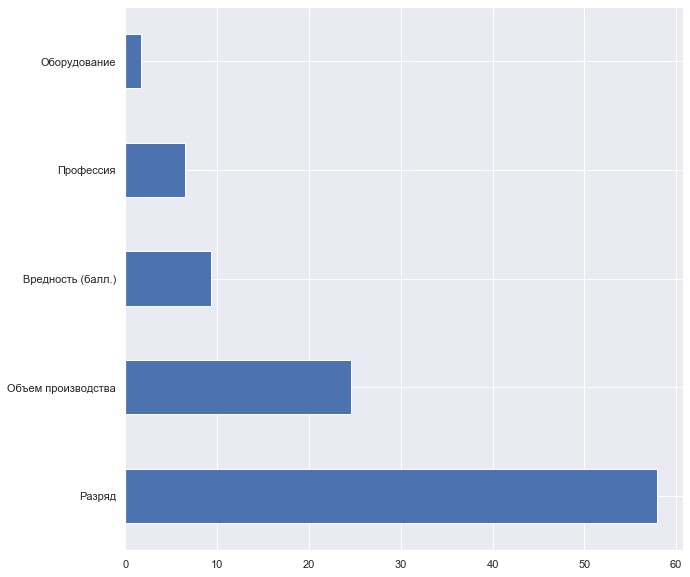

In [101]:
#выведем значимость на графике
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [104]:
feat_importances

Профессия              6.533041
Разряд                57.894839
Оборудование           1.669765
Вредность (балл.)      9.311098
Объем производства    24.591257
dtype: float64

#### SHAP

In [ ]:
интересные результаты дает shap  - библиотека для визуализации вклада фичей в значение таргета

In [162]:
import shap

shap.initjs()

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Pool(X, y, cat_features=cat_cols))

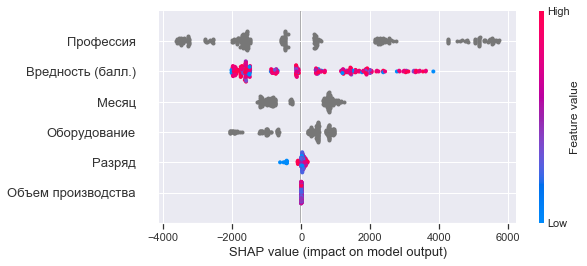

In [109]:
#резюмируем эффект от всех фичей
shap.summary_plot(shap_values, X)

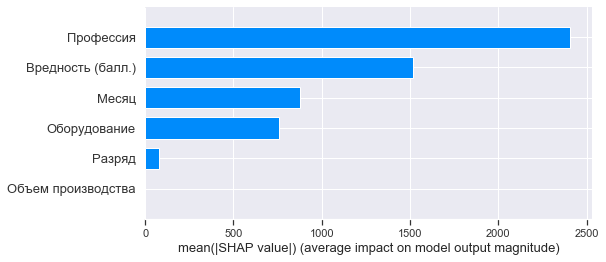

In [111]:
shap.summary_plot(shap_values, X, plot_type="bar")